# Imports

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random

In [2]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('intents.json',encoding="utf8").read()
intents = json.loads(data_file)

## Get Intents

In [3]:

for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [4]:
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)


pickle.dump(words,open('save/words.pkl','wb'))
pickle.dump(classes,open('save/classes.pkl','wb'))

344 documents
68 classes ['Question', 'SARS', 'Spread', 'againcv', 'airborne', 'anim', 'animals', 'anti', 'antibiotics', 'caringsomeone', 'cases worls', 'casesindia', 'childermask', 'cleaning', 'communitywork', 'cure', 'deas', 'do', 'facts', 'familystress', 'food', 'food_spread', 'funeral', 'goodbye', 'greeting', 'helplinelist', 'highbp', 'human', 'incubation', 'laterpositive', 'likely', 'mask', 'month_cal', 'mosquito', 'noanswer', 'nosymptom', 'notdo', 'occur', 'options', 'outbreak', 'package', 'pet', 'precautions', 'protect', 'protection', 'put on', 'quarantine', 'receive', 'risk', 'sanitizer', 'sars', 'source', 'spread_risk', 'stigma', 'surface', 'symptoms', 'temp', 'testforcovid', 'thanks', 'timeperiod', 'vacc', 'vaccine', 'visitplace', 'wear', 'whenmask', 'who', 'whycovid', 'worry']
330 unique lemmatized words ["'s", '(', ')', ',', '-', '.', '19', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '20

## Create training data

In [5]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


/Users/vaibhavkrishnabhosle/opt/anaconda3/envs/mlai/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [6]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(train_y[0]), activation='softmax'))

2021-09-19 16:34:49.663794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
epochs = 100

In [8]:

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=epochs, batch_size=5, verbose=1)

/Users/vaibhavkrishnabhosle/opt/anaconda3/envs/mlai/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2021-09-19 16:34:51.568331: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
69/69 [==============================] - 1s 2ms/step - loss: 4.1101 - accuracy: 0.0552
Epoch 2/100
69/69 [==============================] - 0s 3ms/step - loss: 3.7076 - accuracy: 0.1512
Epoch 3/100
69/69 [==============================] - 0s 4ms/step - loss: 3.3862 - accuracy: 0.1890
Epoch 4/100
69/69 [==============================] - 0s 2ms/step - loss: 3.0566 - accuracy: 0.2936
Epoch 5/100
69/69 [==============================] - 0s 2ms/step - loss: 2.7848 - accuracy: 0.3605
Epoch 6/100
69/69 [==============================] - 0s 2ms/step - loss: 2.5439 - accuracy: 0.3924
Epoch 7/100
69/69 [==============================] - 0s 2ms/step - loss: 2.2786 - accuracy: 0.4448
Epoch 8/100
69/69 [==============================] - 0s 3ms/step - loss: 1.9950 - accuracy: 0.5058
Epoch 9/100
69/69 [==============================] - 0s 2ms/step - loss: 1.7270 - accuracy: 0.5785
Epoch 10/100
69/69 [==============================] - 0s 2ms/step - loss: 1.6023 - accuracy: 0.5930
Epoch 11/

In [9]:
#save model
model.save('save/chatbot_model.h5', hist)

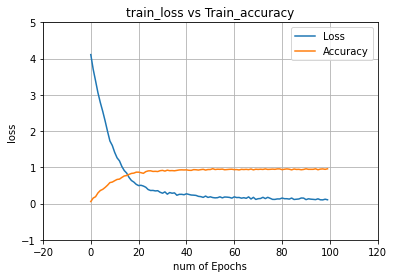

In [10]:
from matplotlib import pyplot as plt
train_loss = hist.history['loss']
train_acc = hist.history['accuracy']
xc = range(epochs)

plt.plot(xc,train_loss)
plt.plot(xc,train_acc)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs Train_accuracy')
plt.grid(True)
plt.legend(['Loss','Accuracy'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])